In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import io
import time
import torch
import torchaudio

In [ ]:
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import numpy as np
import pylab as plt

In [ ]:
# extracted tokens and encoder embeddings
datadir = Path('/mnt/whisper-distil/')

# Distill Whisper with a VQ bottleneck

In [ ]:
import whisper
whmodel = whisper.load_model('tiny.en')
tokenizer = whisper.tokenizer.get_tokenizer(False, language='en')

In [ ]:
speakers = [1649, 2156, 1901, 2607, 2234, 1743, 1614, 3657, 204, 3488, 19, 107, 2162, 1212, 4174]

In [ ]:
# load all embeddings
frames = []
tokens = []
speakerids = []
mb = master_bar(speakers)
for spkid in mb:
    for name in progress_bar(list((datadir/f'whisper-tiny-decoder-{spkid}').rglob('*.whisper')), parent=mb):
        frames.append(torch.load(name))
        tokens += torch.load(name.with_suffix('.tokens'))
        speakerids.append(spkid)

frames = torch.cat(frames)
frames.shape

torch.Size([18202, 1, 1500, 384])

In [ ]:
# the total token count (keep in mind we have 50k+ unique tokens...)
sum([len(t) for t in tokens])

1701133

In [ ]:
# the audio length (in hours)
frames.shape[0] * 30 / 60 / 60

151.68333333333334

In [ ]:
# the transformer model
import whisper
from torch import nn
from vector_quantize_pytorch import VectorQuantize

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

class VQBottleneckTransformer(nn.Module):
    def __init__(self, width=384, vq_codes=512, depth=1, n_head=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False):
        super(VQBottleneckTransformer, self).__init__()
        self.vq_codes = vq_codes
        
        self.in_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_vq = LayerNorm(width)

        self.vq = VectorQuantize(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
        )
        
        self.out_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
                
    def forward(self, xin, tokens=False):
        x = self.ln_vq(self.in_blocks(xin))
        quantized, self.indices, self.commit_loss = self.vq(x)
        x = self.ln_post(self.out_blocks(quantized))
        self.err = torch.tensor(torch.nan)
        if tokens:
            ts = torch.tensor(list(tokenizer.sot_sequence) + tokens).repeat(1,1).cuda()
            with torch.no_grad():
                targets = whmodel.decoder(ts, xin)
            logits = whmodel.decoder(ts, x)
            # I tried KLDivLoss but it did not change much
            loss = (targets - logits).square().mean() + self.commit_loss
            return x, loss
        else:
            return x

In [ ]:
# training code
import torch.optim as optim
import torch.nn.functional as F
import random
import IPython

def train(vqmodel, xs, ys, split=0.2, Loss=nn.L1Loss(), lr=0.01, epochs=10, trainable_decoder=None):
    trainable = list(vqmodel.parameters())
    if trainable_decoder: trainable += list(trainable_decoder.parameters())
    optimizer = optim.SGD(trainable, lr=lr, momentum=0.9)

    idxs = list(range(len(xs)))
    random.shuffle(idxs)
    val_n = int(split * len(idxs))
    train_idxs, val_idxs = idxs[:-val_n], idxs[-val_n:]
    run_valid_every_iters = len(train_idxs)//30

    gs = plt.GridSpec(1, 2, width_ratios=[3, 1])
    gs2 = gs[1].subgridspec(2, 1)
    graph_fig = plt.figure(figsize=(10,4))
    loss_p = graph_fig.add_subplot(gs[0])
    vq_p = graph_fig.add_subplot(gs2[0])
    codebook_p = graph_fig.add_subplot(gs2[1])
    graph_out = display(graph_fig, display_id=True, clear=True)
    
    it = 0
    max_vq_usage = 5
    vq_range = torch.tensor([-2,2,-2,2])
    its = [torch.nan]
    train_losses = [torch.nan]
    val_losses = [torch.nan]
    commit_loss = torch.nan
    used_codes = torch.nan
    mb = master_bar(range(epochs))
    mb.write(["train", "val", "q err", "used codes"], table=True)
    running_loss = []
    for epoch in mb:
        val_loss = 0
        bar = progress_bar(train_idxs, parent=mb)
        for step,i in enumerate(bar):
            # zero the parameter gradients
            optimizer.zero_grad()

            ps, loss = vqmodel(xs[i].to(torch.float32).cuda(), ys[i])
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss.append(loss.item())
            running_loss = running_loss[-100:]
            if it % run_valid_every_iters == 50:
                its.append(it)
                train_losses.append(sum(running_loss)/len(running_loss))
                vqmodel.eval()
                with torch.no_grad():
                    loss = 0
                    commit_loss = 0
                    for i in val_idxs:
                        ps, _loss = vqmodel(xs[i].to(torch.float32).cuda(), ys[i])
                        loss += _loss.item()
                        commit_loss += vqmodel.commit_loss.item()
                    used_codes = (vqmodel.vq._codebook.cluster_size > 0.1).sum()
                    N = len(val_idxs)
                    loss /= N; commit_loss /= N;
                vqmodel.train()
                val_losses.append(loss)
                loss_p.clear()
                loss_p.plot(its, train_losses)
                loss_p.plot(its, val_losses)
                loss_p.set_xlim(0, epochs * len(train_idxs))
                loss_p.set_yscale('log')
                cls = vqmodel.vq._codebook.cluster_size
                max_vq_usage = max_vq_usage * 0.9 + 0.1 * max(max_vq_usage, cls.max().item())
                vq_p.clear()
                vq_p.fill_between(range(cls.shape[1]), 0, torch.sort(cls, descending=True).values.cpu().numpy()[0])
                vq_p.margins(0,0)
                vq_p.spines['top'].set_visible(False)
                vq_p.spines['right'].set_visible(False)
                vq_p.spines['bottom'].set_visible(False)
                vq_p.spines['left'].set_visible(False)
                vq_p.set_ylim(0, max_vq_usage)
                cd = vqmodel.vq.codebook
                vq_range = vq_range * 0.9 + 0.1 * torch.tensor([cd[:,0].min(), cd[:,0].max(), cd[:,1].min(), cd[:,1].max()])
                max_vq_usage = max_vq_usage * 0.9 + 0.1 * max(max_vq_usage, cls.max().item())
                codebook_p.clear()
                codebook_p.scatter(vqmodel.vq.codebook[:,0].cpu(), vqmodel.vq.codebook[:,1].cpu(), s=vqmodel.vq._codebook.cluster_size.cpu(), alpha=.2)
                codebook_p.set_xlim(*vq_range[0:2])
                codebook_p.set_ylim(*vq_range[2:4])
                graph_out.update(graph_fig)

            it += 1
            bar.comment = f"#{epoch+1}/{epochs} loss: {sum(running_loss) / len(running_loss):.3f} / {val_losses[-1]:.3f} commit: {commit_loss:.3f} vq usage: {used_codes:.3f}"
        mb.write([f"{train_losses[-1]:.3f}", f"{val_losses[-1]:.3f}", used_codes], table=True)
    graph_out.update(IPython.display.HTML(''))

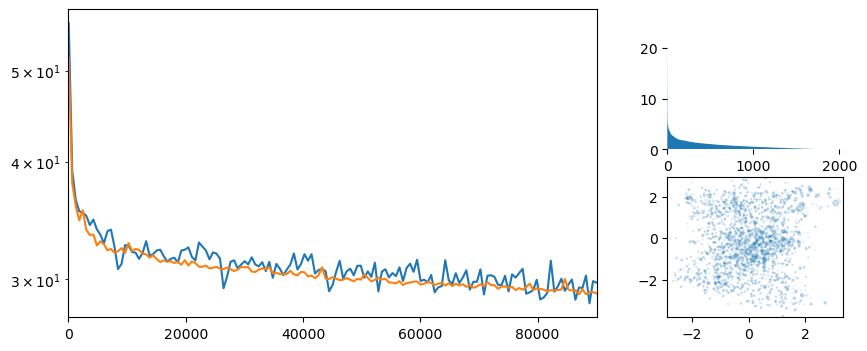

In [ ]:
# simple tranformer (our best VQ model)
vqmodel = VQBottleneckTransformer(codebook_dim=16, vq_codes=2048, n_head=6, depth=2, threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-5, split=0.01)

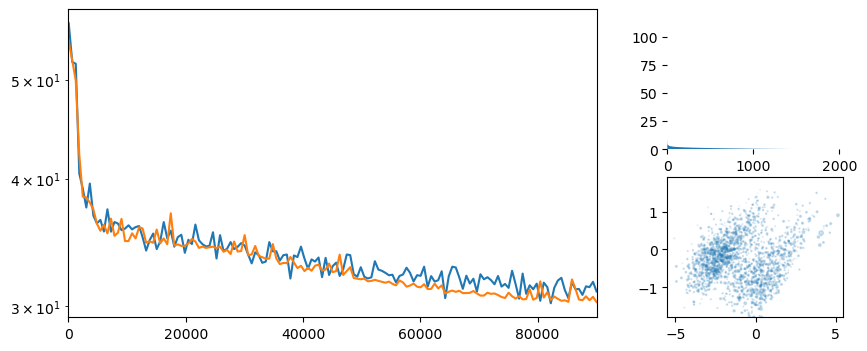

In [ ]:
# the same transformer but 2x more heads and 3x more layers (worse)
vqmodel = VQBottleneckTransformer(codebook_dim=16, vq_codes=2048, n_head=12, depth=6, threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-5, split=0.01)

train,val,q err,used codes
16.932,35.310,nan,1730
32.002,34.212,nan,1697
12.407,33.892,nan,1676
35.158,33.746,nan,1685
32.203,33.185,nan,1665


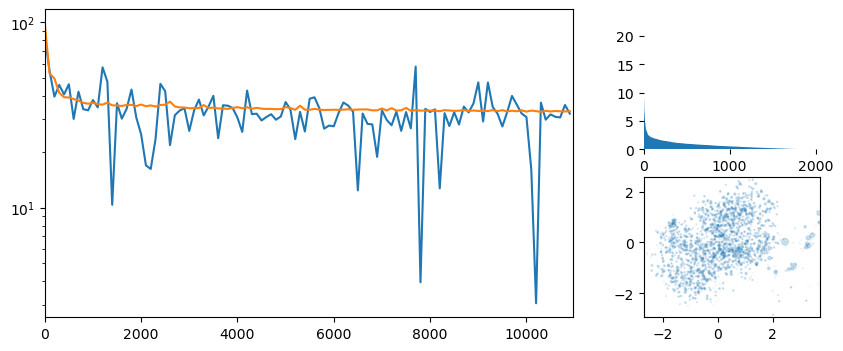

In [ ]:
# small model trained on 7x less data
vqmodel = VQBottleneckTransformer(codebook_dim=16, vq_codes=2048, threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-5, split=0.05)

train,val,q err,used codes
40.848,38.015,nan,998
6.241,37.698,nan,993
31.078,35.489,nan,989
42.022,35.526,nan,999
31.616,34.940,nan,996


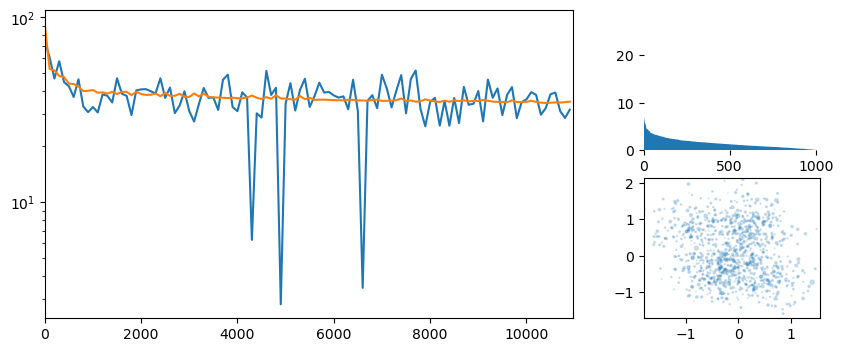

In [ ]:
# bigger model trained on 7x less data
vqmodel = VQBottleneckTransformer(codebook_dim=16, vq_codes=1024, threshold_ema_dead_code=0.1,
                                  n_head=6, depth=3).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-6, split=0.05)

In [ ]:
# MLP models, pretty bad
from torch import nn
from vector_quantize_pytorch import VectorQuantize

class VQBottleneckNonlinear(nn.Module):
    def __init__(self, width=384, vq_codes=512, depth=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False):
        super(VQBottleneckNonlinear, self).__init__()
        self.vq_codes = vq_codes
        
        self.in_layers = nn.Sequential(*[
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Dropout1d(),
        ]*depth)
        
        self.vq = VectorQuantize(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
        )

        self.out_layers = nn.Sequential(*[
            nn.ReLU(),
            nn.Dropout1d(),
            nn.Linear(width, width),
        ]*depth)

    def forward(self, xin, tokens=False):
        x = self.in_layers(xin) + xin
        x, self.indices, self.commit_loss = self.vq(x)
        x = self.out_layers(x) + x
        self.err = torch.tensor(torch.nan)
        if tokens:
            ts = torch.tensor(list(tokenizer.sot_sequence) + tokens).repeat(1,1).cuda()
            with torch.no_grad():
                targets = whmodel.decoder(ts, xin)
            logits = whmodel.decoder(ts, x)
            loss = (targets - logits).square().mean() + self.commit_loss
            return x, loss
        else:
            return x

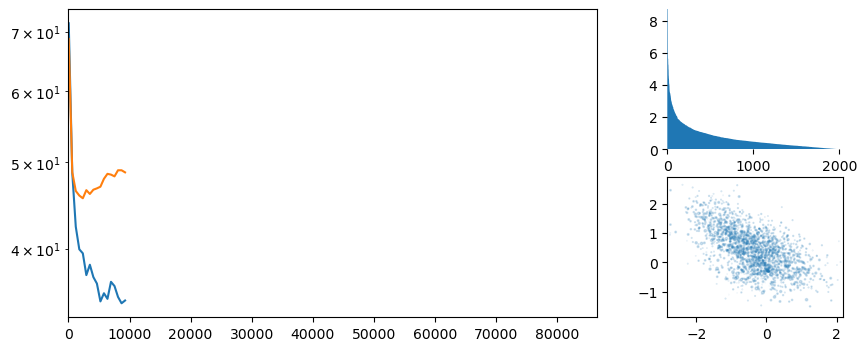

train,val,q err,used codes


KeyboardInterrupt: 

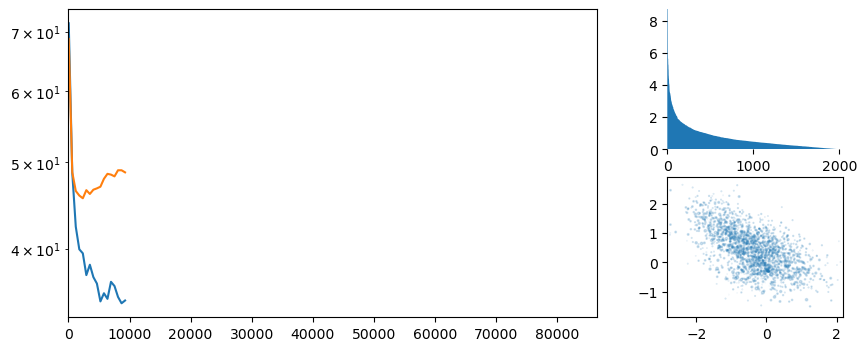

In [ ]:
# stopped training since it was overfitting heavily
vqmodel = VQBottleneckNonlinear(codebook_dim=16, vq_codes=2048, threshold_ema_dead_code=0.1, depth=3).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-6, split=0.05)

In [ ]:
# residual blocks
from torch import nn
from vector_quantize_pytorch import VectorQuantize

class ResBlock(nn.Module):
    def __init__(self, *inner):
        super(ResBlock, self).__init__()
        self.inner = nn.Sequential(*inner)
    
    def forward(self, x):
        return self.inner(x) + x

class VQBottleneckResidual(nn.Module):
    def __init__(self, width=384, vq_codes=512, depth=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False, dropout=0.5):
        super(VQBottleneckResidual, self).__init__()
        self.vq_codes = vq_codes
        
        self.in_layers = nn.Sequential(*[
            ResBlock(
                nn.Linear(width, width//2),
                nn.ReLU(),
                nn.Dropout1d(dropout),
                nn.Linear(width//2, width),
                nn.ReLU(),
            )
        ]*depth)
        
        self.vq = VectorQuantize(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
        )

        self.out_layers = nn.Sequential(*[
            ResBlock(
                nn.ReLU(),
                nn.Linear(width, width//2),
                nn.Dropout1d(dropout),
                nn.ReLU(),
                nn.Linear(width//2, width),
            )
        ]*depth)

    def forward(self, xin, tokens=False):
        x = self.in_layers(xin)
        x, self.indices, self.commit_loss = self.vq(x)
        x = self.out_layers(x)
        self.err = torch.tensor(torch.nan)
        if tokens:
            ts = torch.tensor(list(tokenizer.sot_sequence) + tokens).repeat(1,1).cuda()
            with torch.no_grad():
                targets = whmodel.decoder(ts, xin)
            logits = whmodel.decoder(ts, x)
            loss = (targets - logits).square().mean() + self.commit_loss
            return x, loss
        else:
            return x

train,val,q err,used codes
43.072,39.249,nan,1015
44.673,37.165,nan,1010
18.214,36.171,nan,1019
40.930,35.574,nan,1013
31.842,35.232,nan,1016


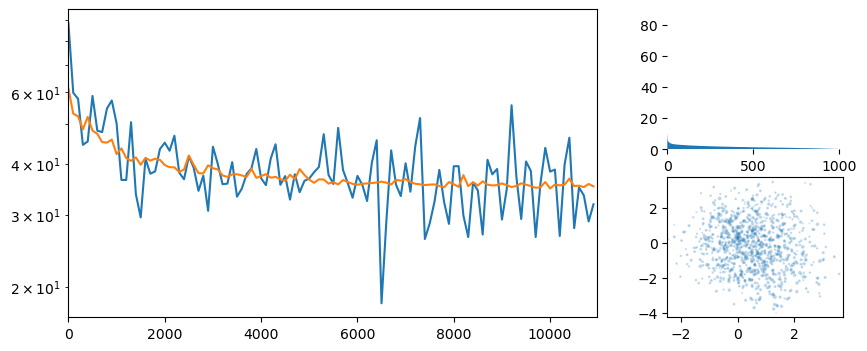

In [ ]:
vqmodel = VQBottleneckResidual(codebook_dim=16, vq_codes=2048, threshold_ema_dead_code=0.1, depth=3).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-5, split=0.05)

train,val,q err,used codes
48.339,45.489,nan,1013
45.755,39.106,nan,1016
29.802,34.941,nan,1012
35.647,34.184,nan,1006
36.224,33.830,nan,1014


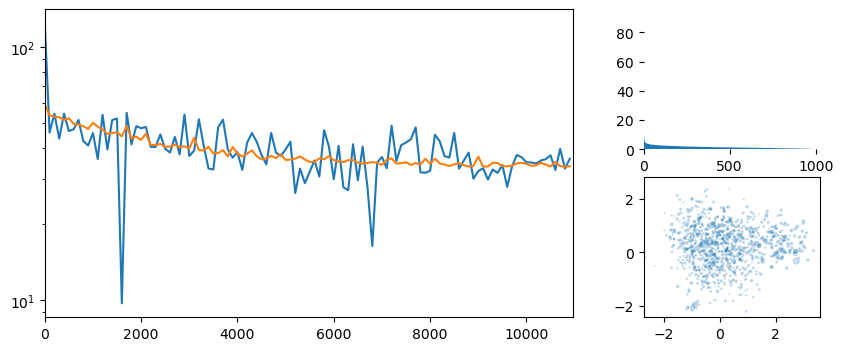

In [ ]:
# FIXME: input/output residual
vqmodel = VQBottleneckResidual(codebook_dim=16, vq_codes=2048, threshold_ema_dead_code=0.1, depth=3).cuda()
train(vqmodel, frames, tokens, epochs=5, lr=1e-5, split=0.05)

In [ ]:
from torch import nn
from vector_quantize_pytorch import VectorQuantize

class ResBlock(nn.Module):
    def __init__(self, *inner):
        super(ResBlock, self).__init__()
        self.inner = nn.Sequential(*inner)
    
    def forward(self, x):
        return self.inner(x) + x

class VQBottleneckResConv(nn.Module):
    def __init__(self, width=384, vq_codes=512, depth=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False):
        super(VQBottleneckResConv, self).__init__()
        self.vq_codes = vq_codes
        
        self.in_layers = nn.Sequential(*[
            ResBlock(
                nn.Conv1d(width, width//2, 5, padding='same'),
                nn.ReLU(),
                nn.Dropout1d(),
                nn.Conv1d(width//2, width, 5, padding='same'),
                nn.ReLU(),
            )
        ]*depth)
        
        self.vq = VectorQuantize(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
        )

        self.out_layers = nn.Sequential(*[
            ResBlock(
                nn.ReLU(),
                nn.Conv1d(width, width//2, 5, padding='same'),
                nn.Dropout1d(),
                nn.ReLU(),
                nn.Conv1d(width//2, width, 5, padding='same'),
            )
        ]*depth)

    def forward(self, xin, tokens=False):
        x = xin.permute(0,2,1)
        x = self.in_layers(x)
        x = x.permute(0,2,1)
        x, self.indices, self.commit_loss = self.vq(x)
        x = x.permute(0,2,1)
        x = self.out_layers(x)
        x = x.permute(0,2,1)
        self.err = torch.tensor(torch.nan)
        if tokens:
            ts = torch.tensor(list(tokenizer.sot_sequence) + tokens).repeat(1,1).cuda()
            with torch.no_grad():
                targets = whmodel.decoder(ts, xin)
            logits = whmodel.decoder(ts, x)
            loss = (targets - logits).square().mean() + self.commit_loss
            return x, loss
        else:
            return x

train,val,q err,used codes
54.723,53.048,nan,1006
52.261,46.498,nan,999
43.214,44.782,nan,997
52.888,43.789,nan,999
44.704,42.645,nan,992
43.342,42.842,nan,1003
44.717,42.896,nan,1004
39.094,41.854,nan,1005
32.562,41.332,nan,996
43.802,41.060,nan,993


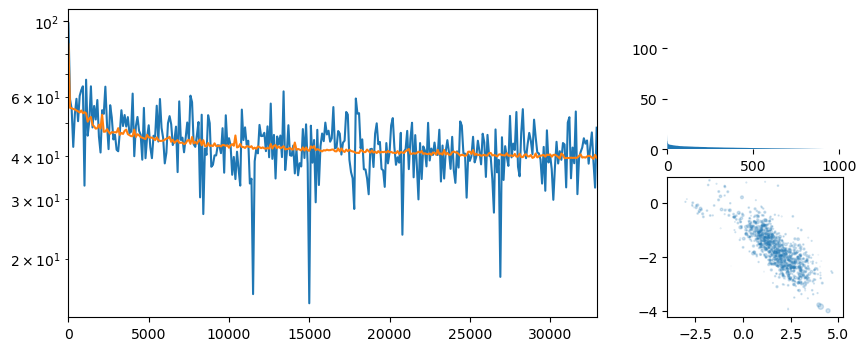

In [ ]:
vqmodel = VQBottleneckResConv(codebook_dim=16, vq_codes=1024, threshold_ema_dead_code=0.1, depth=3).cuda()
train(vqmodel, frames, tokens, epochs=15, lr=1e-5, split=0.05)

## Check how the decoder performs with and without the VQ quantization

In [ ]:
tokenizer.decode(whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens[0]).repeat(1,1).cuda(), frames[0].cuda()).argmax(-1)[0])

'<|nospeech|> CHAPTER 1. Of American History Stories. Volume 1 This is a LibraVox recording. All LibraVox recordings are in the public domain. For more information or development here, please visit LibraVox.org. Recording by Kalinda. American History Stories, Volume 1 By Mar-L Pratt CHAPTER 1 Long ago<|endoftext|>'

In [ ]:
tokenizer.decode(whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens[0]).repeat(1,1).cuda(), vqmodel(frames[0].to(torch.float32).cuda())).argmax(-1)[0])

'<|notimestamps|> the,,,, the the,,,,,,, the,, the the,, the,, the the the, the of the,,,, the, the the,,,,,,,,,,, the,,, the,,,,, the, the,,, the,, the the the, the,, the,, the,, the,,, the the the, the, the,,, the, the the, the the the,,,,,,, the,,,,,, the,,,'

## Training both the bottleneck and the decoder

In [ ]:
import whisper
from torch import nn
from vector_quantize_pytorch import VectorQuantize

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

class VQBottleneckTransformer(nn.Module):
    def __init__(self, width=384, vq_codes=512, depth=1, n_head=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False):
        super(VQBottleneckTransformer, self).__init__()
        self.vq_codes = vq_codes
        
        self.in_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_vq = LayerNorm(width)

        self.vq = VectorQuantize(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
        )
        
        self.out_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
                
    def forward(self, xin, tokens=False):
        x = self.ln_vq(self.in_blocks(xin))
        quantized, self.indices, self.commit_loss = self.vq(x)
        x = self.ln_post(self.out_blocks(quantized))
        self.err = torch.tensor(torch.nan)
        if tokens:
            ts = torch.tensor(list(tokenizer.sot_sequence) + tokens).repeat(1,1).cuda()
            with torch.no_grad():
                targets = whmodel.decoder(ts, xin)
            logits = trainedwh.decoder(ts, x)
            loss = (targets - logits).square().mean() + self.commit_loss
            return x, loss
        else:
            return x

In [ ]:
trainedwh = whisper.load_model('tiny.en')
trainedwh.cuda().train()

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0): ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=384, out_features=384, bias=True)
          (key): Linear(in_features=384, out_features=384, bias=False)
          (value): Linear(in_features=384, out_features=384, bias=True)
          (out): Linear(in_features=384, out_features=384, bias=True)
        )
        (attn_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1536, out_features=384, bias=True)
        )
        (mlp_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): Mult

train,val,q err,used codes
35.061,33.277,nan,1726
30.891,32.832,nan,1699
33.749,34.161,nan,1677
28.546,35.019,nan,1681
19.990,36.211,nan,1645
20.218,37.118,nan,1627
15.158,37.959,nan,1585
14.409,38.436,nan,1605
11.324,40.934,nan,1636
15.081,42.574,nan,1551


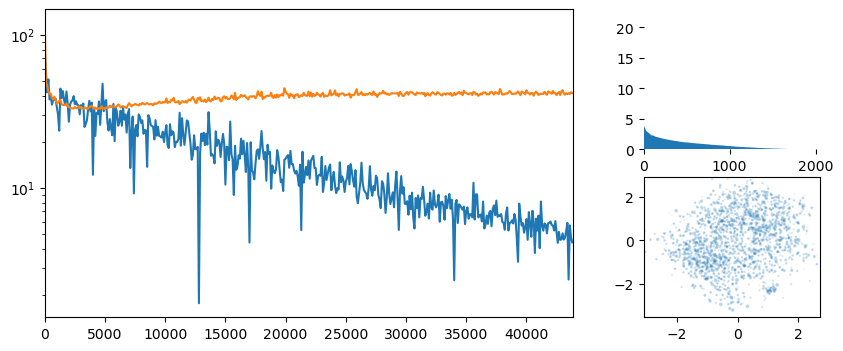

In [ ]:
# finally it overfits! (very quickly though)
vqmodel = VQBottleneckTransformer(codebook_dim=16, vq_codes=2048, threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=20, lr=1e-5, split=0.05, trainable_decoder=trainedwh)

## Residual quantization test

A RQ layer should train a lot better since it passes more bits through the bottleneck without suffering from low codebook usage issues that happen when you bump up the codebook size a lot.

In [ ]:
import whisper
from torch import nn
from vector_quantize_pytorch import ResidualVQ

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

class PseudoVQ():
    pass
    
class RQBottleneckTransformer(nn.Module):
    def __init__(self, width=384, vq_codes=512, q_depth=12, depth=1, n_head=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False):
        super(RQBottleneckTransformer, self).__init__()
        self.vq_codes = vq_codes
        
        self.in_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_vq = LayerNorm(width)

        self.vqs = ResidualVQ(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
            num_quantizers= q_depth,
        )
        # quick hack to make the training loop happy
        self.vq = PseudoVQ()
        self.vq._codebook = self.vqs.layers[0]._codebook
        self.vq.codebook = self.vq._codebook.embed.squeeze()
        
        self.out_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
                
    def forward(self, xin, tokens=False):
        x = self.ln_vq(self.in_blocks(xin))
        quantized, self.indices, self.commit_loss = self.vqs(x)
        self.commit_loss = self.commit_loss.mean()
        x = self.ln_post(self.out_blocks(quantized))
        self.err = torch.tensor(torch.nan)
        if tokens:
            ts = torch.tensor(list(tokenizer.sot_sequence) + tokens).repeat(1,1).cuda()
            with torch.no_grad():
                targets = whmodel.decoder(ts, xin)
            logits = whmodel.decoder(ts, x)
            loss = (targets - logits).square().mean() + self.commit_loss
            return x, loss
        else:
            return x

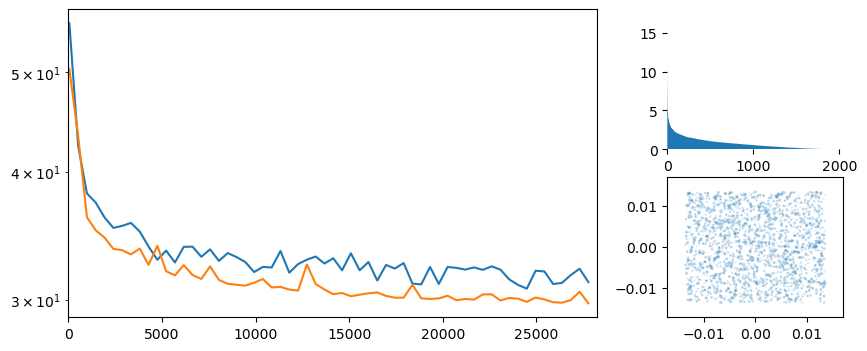

In [ ]:
# Try to reproduce the single VQ block result
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=2048, n_head=6, depth=2, q_depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=2, lr=1e-5, split=0.01)

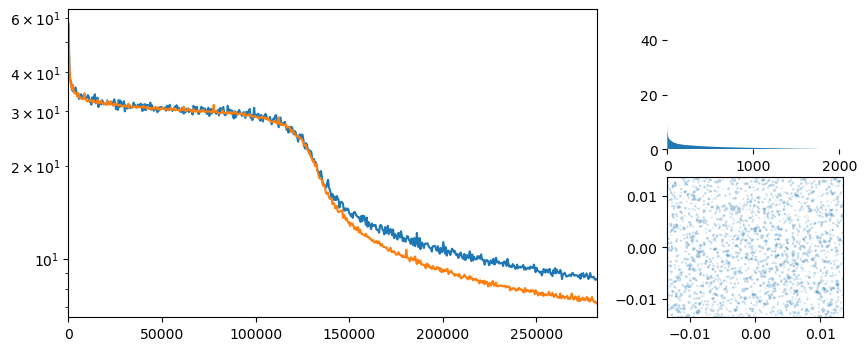

In [ ]:
# 6x more bits but no improvement vs. the single VQ block
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=2048, n_head=6, depth=2, q_depth=6,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=20, lr=1e-5, split=0.01)

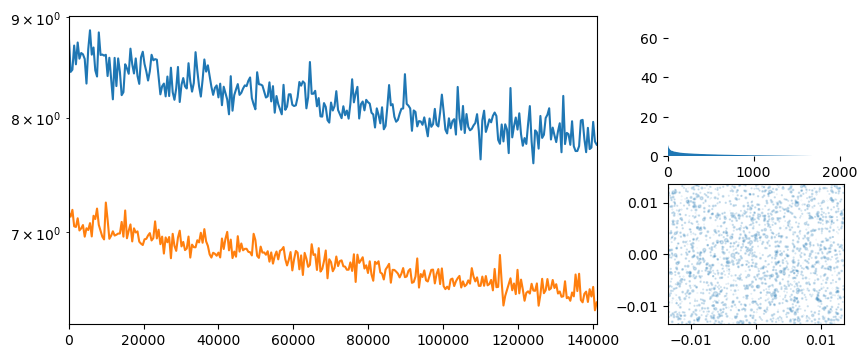

In [ ]:
# let's train for a few more epochs
train(vqmodel, frames, tokens, epochs=10, lr=0.5e-5, split=0.01)

## Check how the decoder performs with and without the RQ quantization

In [ ]:
tokenizer.decode(whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens[0]).repeat(1,1).cuda(), frames[0].cuda()).argmax(-1)[0])

'<|nospeech|> CHAPTER 1. Of American History Stories. Volume 1 This is a LibraVox recording. All LibraVox recordings are in the public domain. For more information or development here, please visit LibraVox.org. Recording by Kalinda. American History Stories, Volume 1 By Mar-L Pratt CHAPTER 1 Long ago<|endoftext|>'

In [ ]:
tokenizer.decode(whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens[0]).repeat(1,1).cuda(), vqmodel(frames[0].to(torch.float32).cuda())).argmax(-1)[0])

' "APTER 1.<|endoftext|><|endoftext|> a History, CH 1<|endoftext|> is a numberra-OC\'s, A theraVox are are in the " domain. For a than or to care, visit wwwraVox.org.<|endoftext|> by Chi A History,, 1<|endoftext|> Mla,<|endoftext|>APTER 1<|endoftext|>er<|endoftext|>'